# Wellbeing Police

From various subreddit, we have scraped close to 4000 posts. The subreddits include "r/SuicideWatch", "r/BipolarReddit", "r/Anxiety", "r/AnxietyDepression", "r/Depression", and "r/Happy". Each of the subreddit posts currently sitting within its own csv file. We will see what are the fields that are consistent across the CSV files and choose those applicable. Clean up the data, removed the columns not needed. 

As all the scrapes was created from the same script, the columns of the resulting csv are same across the files. 
We will proceed to label them according to the subreddit they came from and combine them into a single dataframe.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import os
import spacy
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

from src.utils import color_func, get_mask, search,text_normalization

### Data Combination and Labeling

We retrieved posts in “Hot” section from various subreddits:
`r/ptsd`,`r/Anxiety`,`r/SuicideWatch`,`r/depression`,`r/BipolarReddit`,`r/schizophrenia`,`r/EDAnonymous`,`r/EatingDisorders`

In [3]:
path = "./reddit/csvs/"
all_csvs = glob.glob(os.path.join(path, "*.csv"))

all_dfs = []
for filename in all_csvs:
    df = pd.read_csv(filename, index_col=None, header=0)
    df = df[["title", "subreddit", "body"]]
    
    # ## manually remove irrelevant pinned posts
    # if df.iloc[0].subreddit in ["ptsd",'Anxiety',"SuicideWatch",'EDAnonymous']: 
    #     df=df[2:]
    # if df.iloc[0].subreddit in ['BipolarReddit','schizophrenia','EatingDisorders']:
    #     df=df[1:]
        
    all_dfs.append(df)

main_df = pd.concat(all_dfs)
print(main_df.shape)
main_df = main_df.drop_duplicates()
print(main_df.shape)
main_df.head()


(34857, 3)
(23741, 3)


,title,subreddit,body
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...
1,Survey thread,ptsd,If you have a survey you would like to share w...
2,Processing my trauma requires feeling safe but...,ptsd,And apparently I’m stuck in this loop because ...
3,My sister is the strongest person I know. She’...,ptsd,"My sister has been bravely battling PTSD, bipo..."
4,Has anyone else found mushrooms helped?,ptsd,At a point where I was immediately post assaul...


A few of the subreddit is indicating the same underlying mental problems, we proceed to add an attribute such that these minor differentiation will be grouped for better and easier identification.

In [4]:
sub_problem_mapping = {
    "ptsd": "PTSD",
    "CPTSD": "PTSD",
    "Anxiety": "anxiety",
    "Anxietyhelp": "anxiety",
    "SuicideWatch": "suicidal",
    "selfharm": "suicidal",
    "depression": "depression",
    "depression_help": "depression", 
    "BipolarReddit": "bipolar", 
    "bipolar": "bipolar",
    "schizophrenia": "schizophrenia",
    "EDAnonymous": "eating disorder",
    "EatingDisorders": "eating disorder",
    "happy": "control",
    "MadeMeSmile": "control"
}

main_df["problem"] = [sub_problem_mapping[s] for s in main_df["subreddit"]]
main_df.head()


,title,subreddit,body,problem
0,Self Help and Self Care Resources,ptsd,Unfortunately this is a small subreddit and as...,PTSD
1,Survey thread,ptsd,If you have a survey you would like to share w...,PTSD
2,Processing my trauma requires feeling safe but...,ptsd,And apparently I’m stuck in this loop because ...,PTSD
3,My sister is the strongest person I know. She’...,ptsd,"My sister has been bravely battling PTSD, bipo...",PTSD
4,Has anyone else found mushrooms helped?,ptsd,At a point where I was immediately post assaul...,PTSD


### Text Cleaning and Processing
- Remove emoticons and non-text characters
- Remove excess newline and spacing characters added for emphasis (e.g., poetry paragraphing)
- Remove hyperlinks and tags
- Change text to lowercase
- Simplify punctuation by removing repeated characters (e.g., "?????", "!!!!")

In [5]:
from text_processing import text_processing

In [6]:

clean_text = text_processing()

clean_text.process_data(main_df, headers = ['title', 'subreddit', 'body'])

main_df.head()

,title,subreddit,body,problem
0,self help and self care resources,ptsd,unfortunately this is a small subreddit and as...,PTSD
1,survey thread,ptsd,if you have a survey you would like to share w...,PTSD
2,processing my trauma requires feeling safe but...,ptsd,and apparently i’m stuck in this loop because ...,PTSD
3,my sister is the strongest person i know. she’...,ptsd,"my sister has been bravely battling ptsd, bipo...",PTSD
4,has anyone else found mushrooms helped?,ptsd,at a point where i was immediately post assaul...,PTSD


### Apply further text normalization steps, tokenization and  lemmatization using spaCy

We scrap common text abbreviations into a dictionary from below link and also manually added in some common abbreviate words. https://www.slicktext.com/blog/2019/02/text-abbreviations-guide/

We use spaCy to perform tokenization and lemmatization.

In [8]:
# # Group the data by class label
# groups = main_df.groupby('problem')

# # Sample 2 rows from each group
# sampled_data = groups.apply(lambda x: x.sample(n=100)).reset_index(drop=True)

## Apply further cleaning steps before tokenization
normalized_text = text_normalization()

normalized_text.normalize_data(main_df)

,title,subreddit,body,problem
0,self help and self care resources,ptsd,unfortunately this is a small subreddit and as...,PTSD
1,survey thread,ptsd,if you have a survey you would like to share w...,PTSD
2,processing my trauma requires feeling safe but...,ptsd,and apparently i’m stuck in this loop because ...,PTSD
3,my sister is the strongest person i know. she’...,ptsd,"my sister has been bravely battling ptsd, bipo...",PTSD
4,has anyone else found mushrooms helped?,ptsd,at a point where i was immediately post assaul...,PTSD
...,...,...,...,...
995,advice on how to navigate my husband's highs a...,bipolarreddit,"hey guys, i'm here because my husband is diagn...",bipolar
996,brain damage caused by mania,bipolarreddit,has anyonebactually gone through any testing t...,bipolar
997,i'm scared for my future,bipolarreddit,i realize this disorder gets worse with age an...,bipolar
998,what do you use for birth control?,bipolarreddit,"those of you with a period, what do you use fo...",bipolar


In [9]:
nlp = spacy.load('en_core_web_sm')
    
def lemmatize(text):
    doc = nlp(text)
    
    # Turn it into tokens, ignoring the punctuation
    tokens = [token for token in doc if not token.is_punct]
    
    # ignoring the stopwords
    tokens = [ token for token in tokens if not token.is_stop]
     
    # Convert those tokens into lemmas, EXCEPT the pronouns
    lemmas = [token.lemma_ if token.pos_ != 'PRON' else token.orth_ for token in tokens]
    return lemmas

In [ ]:
# ## Directly apply lemmatize function to documents to get tokenized text
# # document_lemmatized = [lemmatize(post) for post in documents]
# # document_lemmatized  

### Create Document-Term Matrices using TF-IDF Weights with N-grams

- restrict the vocabulary to some maximum size to 15000
- set range of n-gram sizes from 1 to 3

In [ ]:
### Create TF-IDF vector for all documents for traning t
documents = main_df.body

tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),max_features=15000)
text_tfidf = tfidf_vectorizer.fit_transform(documents)
text_tfidf = np.asarray(text_tfidf.todense())

tokens = tfidf_vectorizer.get_feature_names_out()

### Visualize text using work cloud and TF-IDF

We convert documents with same problem into each TF-IDF vector and visulize the vector to see top 500 words in high TF-IDF weights for each problem.

Word cloud of posts from problem PTSD


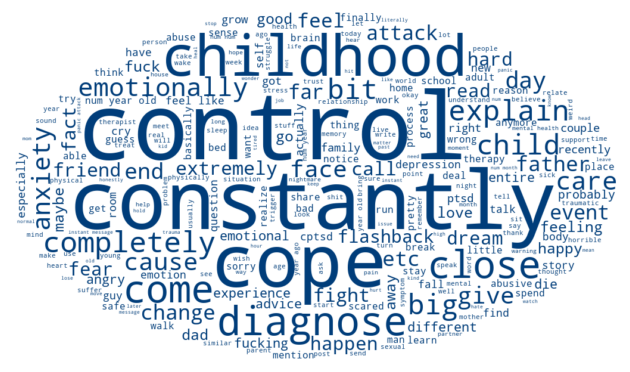

Word cloud of posts from problem suicidal


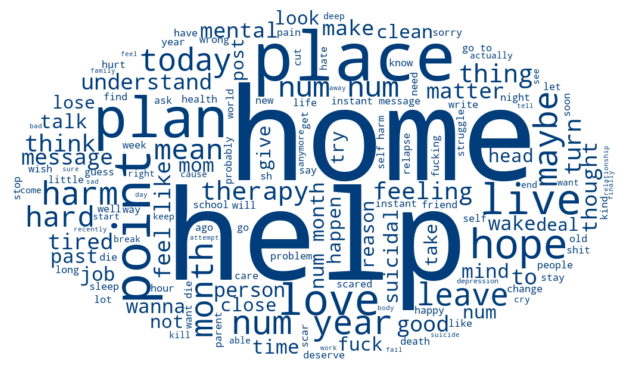

Word cloud of posts from problem eating disorder


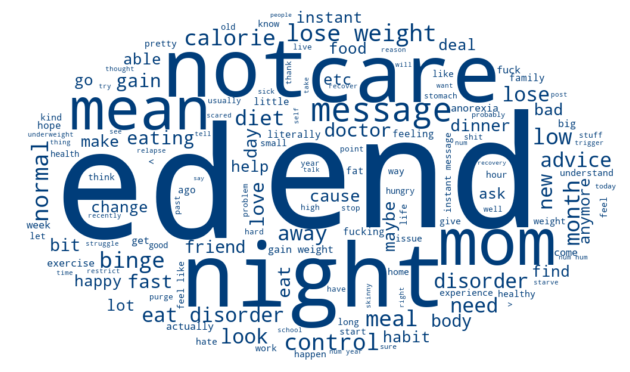

Word cloud of posts from problem bipolar


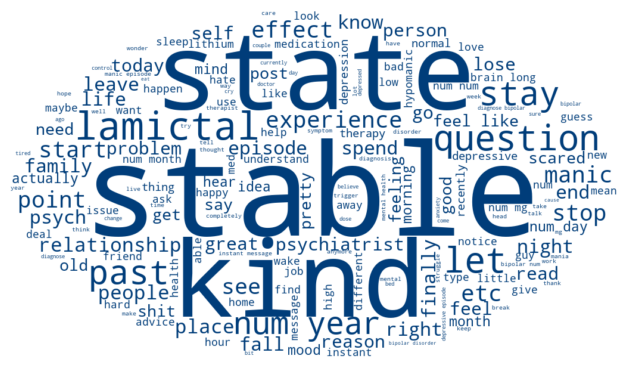

Word cloud of posts from problem schizophrenia


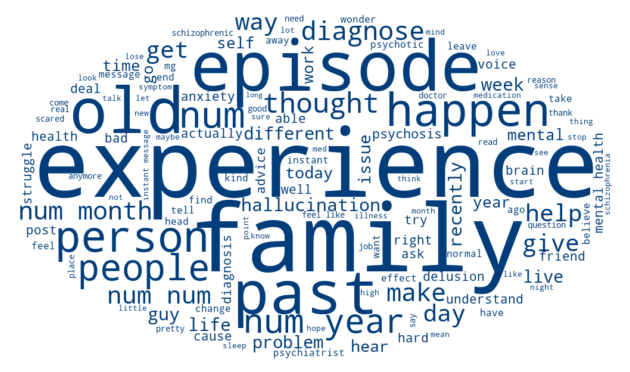

Word cloud of posts from problem depression


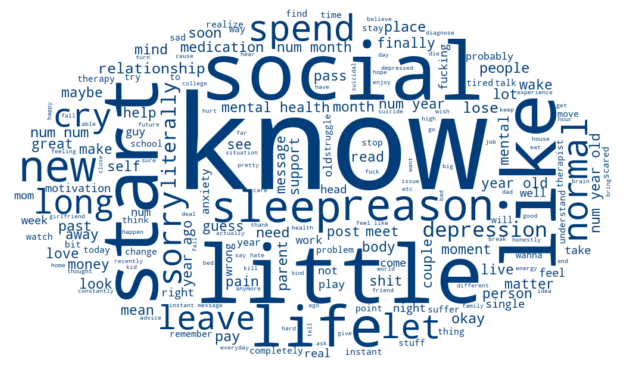

Word cloud of posts from problem anxiety


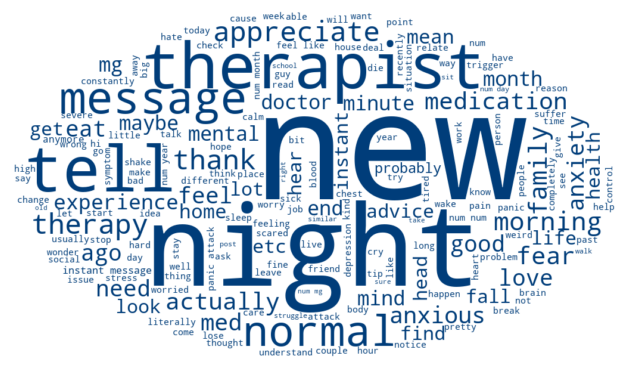

Word cloud of posts from problem control


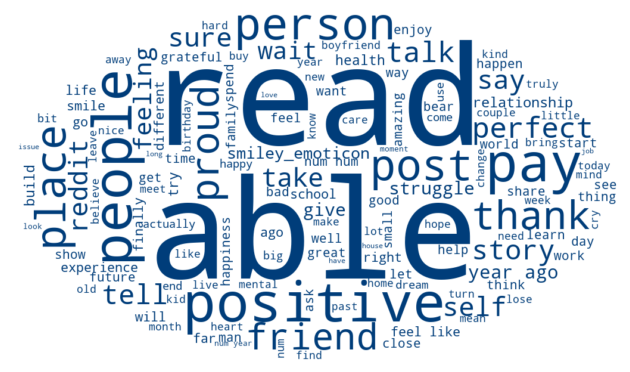

In [18]:
for syp in main_df.problem.unique():
    df_problem = main_df[main_df['problem'] == syp]
    
    problem_documents=df_problem.body
    
# for syp in sampled_data.problem.unique():

#     problem_documents = sampled_data[sampled_data['problem'] == syp]['body']
    
    print(f"Word cloud of posts from problem {syp}")
    
    problem_tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, 3),min_df=0.05)
    
    problem_text_tfidf = problem_tfidf_vectorizer.fit_transform(problem_documents)
    problem_text_tfidf= np.asarray(problem_text_tfidf.todense())
    tokens = problem_tfidf_vectorizer.get_feature_names_out()
    
    
    problem_weights = list(problem_text_tfidf[np.nonzero(problem_text_tfidf)])
    problem_word_freqs = { w:problem_weights[idx]  for (idx, w) in enumerate(tokens) }

    wc = WordCloud(color_func=color_func, 
                   background_color="white", 
                   mask=get_mask(),
                   max_words=500,
                   contour_width=0)

    wc.generate_from_frequencies(problem_word_freqs)

    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

### KNN-Classification

#### Create Training & Test Set

With the method `train_test_split()`, set the size of the test set to 20%.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import metrics
from sklearn.pipeline import Pipeline

from tqdm import tqdm

#### KNN simple (Ngram = 1 , K = 7)

In [ ]:
sentences = main_df.body
labels = main_df.problem
num_labels = len(labels.unique()) ##should be 7
print("Size of label/class : {}".format(num_labels))

# Split sentences and labels into training and test set with a test set size of 20%
sentences_train, sentences_test, labels_train, labels_test = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# We can directly convert the numerical class labels from lists to numpy arrays
y_train = np.asarray(labels_train)
y_test = np.asarray(labels_test)

print("Size of training set: {}".format(len(sentences_train)))
print("Size of test set: {}".format(len(sentences_test)))

In [ ]:
#Commented (use jenny tfidf above)
#tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=20000)

X_train = tfidf_vectorizer.fit_transform(sentences_train)
X_test = tfidf_vectorizer.transform(sentences_test)

In [ ]:
knn = KNeighborsClassifier(n_neighbors=num_labels).fit(X_train, y_train)

In [ ]:
#Prediction 
y_pred = knn.predict(X_test)
precision = metrics.precision_score(y_test, y_pred, average='micro')
recall = metrics.recall_score(y_test, y_pred, average='micro')
f1 = metrics.f1_score(y_test, y_pred, average='micro')

print("Precison: {:.3f}".format(precision))
print("Recall:   {:.3f}".format(recall))
print("F1 score: {:.3f}".format(f1))
print(metrics.classification_report(y_test, y_pred))

#### KNN with Iteration to find best N-gram (1-3)

In [ ]:
k_sizes = [7]
#k_sizes = [7, 17, 27]

max_ngram_size = 3
num_k = len(k_sizes)

# Number runs = number traing/test a KNN classifier
num_runs = max_ngram_size * num_k

# numpy array to keep track of all results
knn_results = np.zeros((max_ngram_size, num_k))

with tqdm(total=num_runs) as pbar:
    for i, ngram in enumerate(range(1, max_ngram_size+1)):
        # Create Document-Term Matrix for different n-gram sizes
        #tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngram), max_features=20000)
        tfidf_vectorizer = TfidfVectorizer(tokenizer=lemmatize, norm='l1',ngram_range=(1, ngram),max_features=15000)
        X_train = tfidf_vectorizer.fit_transform(sentences_train)
        X_test = tfidf_vectorizer.transform(sentences_test)
        # Train & test model using cross validation
        for j, k in enumerate(k_sizes):
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, X_train, y_train, cv=10, scoring="f1_micro")
            mean_score = np.mean(scores)
            knn_results[i,j] = mean_score
            pbar.update(1)

In [ ]:
# Use the heatmap function from the seaborn package
plt.figure()

sns.heatmap(knn_results, annot=True, cmap="crest", xticklabels=k_sizes, yticklabels=list(range(1,max_ngram_size+1)))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Maximum N-Gram Size', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=16)

plt.show()